## Causal graph using score based structure learning with the GES algorithm.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import networkx as nx
import dowhy
import pandas as pd
from dowhy import CausalModel

style.use('fivethirtyeight') # bmh

import math
import dowhy.datasets, dowhy.plotter

import hyppo
import pingouin as pg
import conditional_independence

from hyppo.independence import Hsic

# the code below simple hides some warnings we don't want to see
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

In [4]:
path = "/Users/keerthybalan/Documents/cds/CausalDS_LUCAS-main/Data/lucas0_text/"
names = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']

In [5]:
# reading csv files
train =  pd.read_csv(path + 'lucas0_train.data', sep=" ", header = None)
train.drop(11, inplace = True, axis = 1)
train.columns = names
test =  pd.read_csv(path + 'lucas0_test.data', sep=" ", header = None)
test.drop(11, inplace = True, axis = 1)
test.columns = names
target =  pd.read_csv(path + 'lucas0_train.targets', sep=" ", header = None)
# param =  pd.read_csv(path + 'lucas0.param', sep=" ")
train["Target"] = np.array(target)
train["Target"] = train["Target"].apply(lambda x: 0 if x==-1 else x)
train.rename(columns={'Target': 'Lung_Cancer'}, inplace=True)

In [6]:
train.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


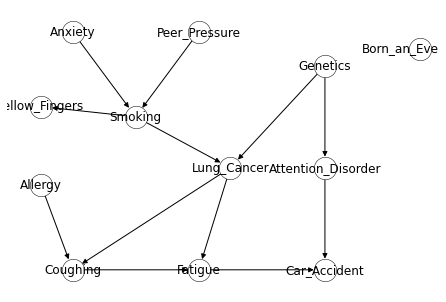

In [7]:
nodes = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing', 'Lung_Cancer']
true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
pos = {'Anxiety': (-20, 40),              'Yellow_Fingers': (-25, 18),
         'Peer_Pressure': (0, 40), 'Smoking': (-10, 15), 'Allergy': (-25, -5),
         'Coughing': (-20, -30), 'Lung_Cancer': (5, 0), 'Genetics': (20, 30), 'Attention_Disorder': (20, 0),
         'Fatigue': (0, -30),'Car_Accident': (20, -30), 'Born_an_Even_Day' : (35,35)}
         
true_graph.add_edges_from([('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_Cancer'), 
                  ('Allergy','Coughing'), ('Lung_Cancer','Coughing'), ('Coughing','Fatigue'), ('Lung_Cancer','Fatigue'),
                 ('Genetics','Lung_Cancer'), ('Genetics','Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Fatigue', 'Car_Accident')])

nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

In [8]:
import ges

In [9]:
train

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [10]:
data = train.to_numpy()
print(data)

[[0 0 1 ... 1 0 0]
 [0 1 0 ... 0 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 1 ... 0 1 1]
 [1 1 0 ... 1 1 1]]


We check the final learned graph from calling ```fit_bic()```. GES contains forward phase and backward phase.

In [12]:
def get_colors(G):
    edges = G.edges()
    for (x, y) in G.edges():
        if (y, x) in edges:
            # bi-directional edge
            nx.set_edge_attributes(G, {(x, y): {"directed": False}})
        else:
            nx.set_edge_attributes(G, {(x, y): {"directed": True}})
    colors = ['black' if G[u][v]['directed']==True else 'r' for u,v in G.edges()]
    return colors

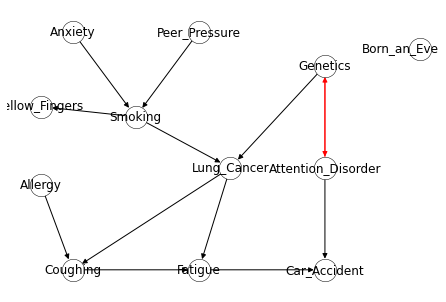

In [13]:
estimate, score = ges.fit_bic(data, phases=['forward', 'backward'], debug=0)
H = nx.DiGraph()
H = nx.from_numpy_array(estimate, create_using=nx.DiGraph)
mapping = dict(zip(H.nodes, nodes))
H = nx.relabel_nodes(H, mapping)
colors = get_colors(H)
nx.draw(H, with_labels=True, node_size=500, node_color='w', 
        edgecolors ='black', pos=pos, edge_color=colors)

Now, we look at the learning process step-by-step. 
We first initalize a Gaussian BIC score object. This object will pre-compute and cache l0-penalized gaussian likelihood scores. By default, we use the 'scatter' method and the empirical covariance matrix to compute the likelihood.

In [14]:
from ges.scores.gauss_obs_l0_pen import GaussObsL0Pen
# initalize the Gaussian BIC score
cache = GaussObsL0Pen(data)
print(cache._scatter)

[[ 0.18624375  0.138045    0.08354875  0.03052125  0.00152625  0.00081875
  -0.00484875  0.0099425   0.0309075   0.0073925   0.05187375  0.09507125]
 [ 0.138045    0.170476    0.061449    0.022447   -0.000589    0.001305
  -0.001289    0.009114    0.022666    0.009274    0.039209    0.069787  ]
 [ 0.08354875  0.061449    0.23296975  0.00068425  0.00104525 -0.00333625
  -0.00912975  0.0066485   0.0108215   0.0042385   0.03033475  0.04109425]
 [ 0.03052125  0.022447    0.00068425  0.22487775  0.00336075  0.00336625
  -0.00166425  0.0050955   0.0058145  -0.0011345   0.01077925  0.01210775]
 [ 0.00152625 -0.000589    0.00104525  0.00336075  0.12003975  0.04351125
  -0.00378525  0.0226415   0.0151885  -0.0013485   0.02178025  0.03535075]
 [ 0.00081875  0.001305   -0.00333625  0.00336625  0.04351125  0.21849375
  -0.00486375  0.0633325   0.0068175   0.0043825   0.01158875  0.01431625]
 [-0.00484875 -0.001289   -0.00912975 -0.00166425 -0.00378525 -0.00486375
   0.24988975 -0.0069085  -0.00626

Following this, we run the learning process that includes the forward phase and backward phase. In the forward phase, an edge is added at each step, while edges are removed for the backward phase.

The graph is stored in an adjacency matrix A where ```A[i][j] = 1``` indicates the existence of a directed edge going from i to j, and ```A[i][j] = 0``` otherwise.

Because we are searching the Markov Equivalence Class, every step we will validate if the operation meets two conditons (see paper) and therefore is a valid operation.

In [15]:
# define parameters
phases = ['forward', 'backward']
debug = 3
iterate = False
score_class = cache

In [17]:
# The code below is taken directly from the GES library
from ges import forward_step, backward_step, turning_step
import ges.utils as utils

# Unless indicated otherwise, initialize to the empty graph
A0 = np.zeros((cache.p, cache.p))
# initialize the score and adjacency matrix
A, score_change = A0, np.Inf

# Set the completion algorithm
completion_algorithm = utils.pdag_to_cpdag
# GES procedure
total_score = 0

inter_adjs = []
inter_scores = []
# Run each phase
while True:
    last_total_score = total_score
    for phase in phases:
        if phase == 'forward':
            fun = forward_step
        elif phase == 'backward':
            fun = backward_step
        elif phase == 'turning':
            fun = turning_step
        else:
            raise ValueError('Invalid phase "%s" specified' % phase)
        print("\nGES %s phase start" % phase) if debug else None
        print("-------------------------") if debug else None
        while True:
            score_change, new_A = fun(A, score_class, max(0, debug - 1))
            if score_change > 0:
                A = completion_algorithm(new_A)
                inter_adjs.append(A)
                total_score += score_change
                inter_scores.append(total_score)
            else:
                break
        print("-----------------------") if debug else None
        print("GES %s phase end" % phase) if debug else None
        print("Total score: %0.4f" % total_score) if debug else None
        [print(row) for row in A] if debug else None
    if total_score <= last_total_score or not iterate:
        break


GES forward phase start
-------------------------
  132 candidate edges
    insert(0,1,[]) -> 912.9918467260011994
    insert(0,2,[]) -> 171.5996095573147500
    insert(0,3,[]) -> 18.6927683461438505
    insert(0,4,[]) -> -3.6962513565374593
    insert(0,5,[]) -> -3.7839777450623160
    insert(0,6,[]) -> -3.2951630342355429
    insert(0,7,[]) -> -1.1466550626827257
    insert(0,8,[]) -> 23.0179784806930456
    insert(0,9,[]) -> -2.4975113759028318
    insert(0,10,[]) -> 67.5522694228516229
    insert(0,11,[]) -> 272.6399116839490944
    insert(1,0,[]) -> 912.9918467260013131
    insert(1,2,[]) -> 96.1028874348328941
    insert(1,3,[]) -> 9.4300616820458458
    insert(1,4,[]) -> -3.7834982539768589
    insert(1,5,[]) -> -3.7547288647367623
    insert(1,6,[]) -> -3.7614478164800857
    insert(1,7,[]) -> -1.3645168521697997
    insert(1,8,[]) -> 11.8692776045810433
    insert(1,9,[]) -> -1.5591612687434235
    insert(1,10,[]) -> 40.1343546809360987
    insert(1,11,[]) -> 149.555108691332

From the output, we can see that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and the score change of the insertion or deletion is calculated. 

Considering all edge candidates and a set of potential variables that might form a v-structure (all possible subsets of neighbors of y which are NOT adjacent to x), the algorithm chooses the best operation for the highest score gain. 

We keep inserting/deleting edges until no action will result in a positive score gain.

We can also visualize the whole process and each step by drawing the current graph. We can see how the graph changes while we are adding more edges and how the addition of certain edges orients other edges.

In [18]:
def draw_from_adj(Adj):
    print(Adj)
    H = nx.MultiGraph()
    H = nx.from_numpy_array(Adj, create_using=nx.DiGraph)
    mapping = dict(zip(H.nodes, nodes))
    H = nx.relabel_nodes(H, mapping)
    colors = get_colors(H)
    nx.draw(H, with_labels=True, node_size=500, node_color='w', 
            edgecolors ='black', pos=pos, edge_color=colors)
    return H

Total_score:  0
--------Step: 1--------
Total_score:  912.9918467260013
[[0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


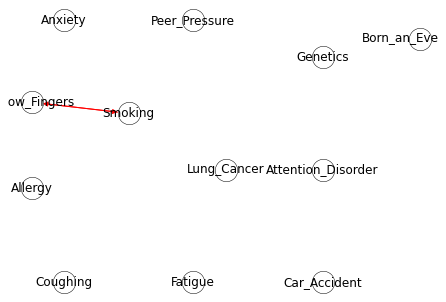

--------Step: 2--------
Total_score:  1219.7716149827265
[[0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


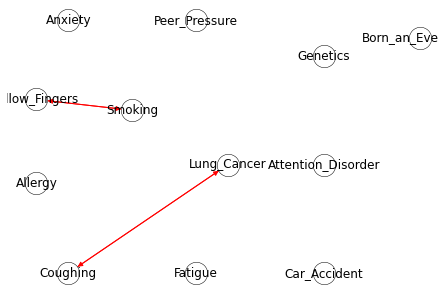

--------Step: 3--------
Total_score:  1492.4115266666756
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


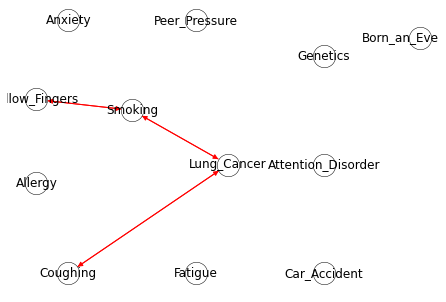

--------Step: 4--------
Total_score:  1729.4401202911151
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


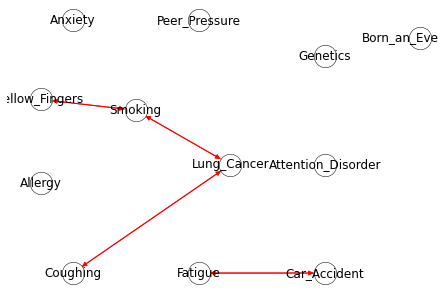

--------Step: 5--------
Total_score:  1963.210664683093
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


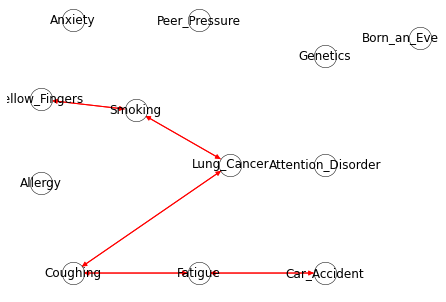

--------Step: 6--------
Total_score:  2134.810274240408
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


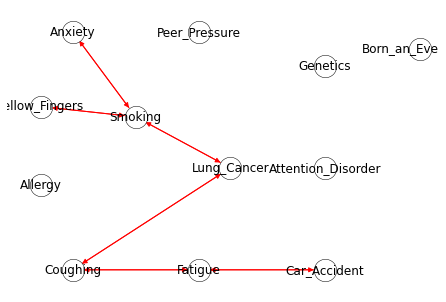

--------Step: 7--------
Total_score:  2281.7698789445685
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


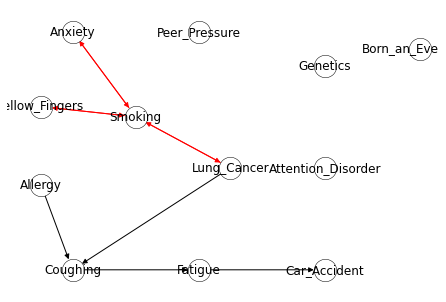

--------Step: 8--------
Total_score:  2389.15904299184
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


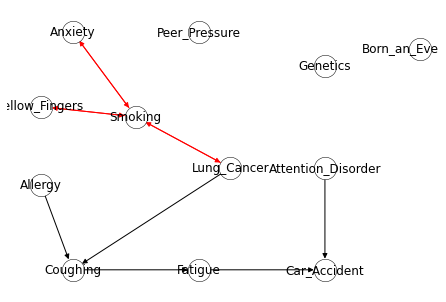

--------Step: 9--------
Total_score:  2460.280088596815
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


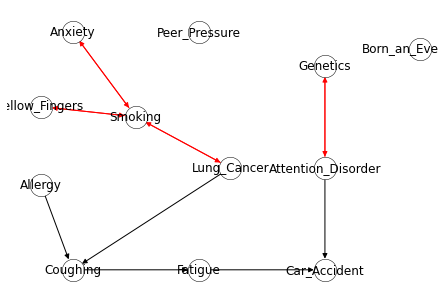

--------Step: 10--------
Total_score:  2524.0482661563083
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


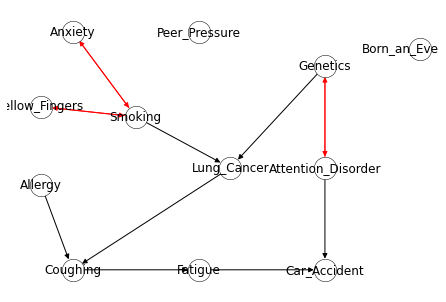

--------Step: 11--------
Total_score:  2550.4102820328862
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]]


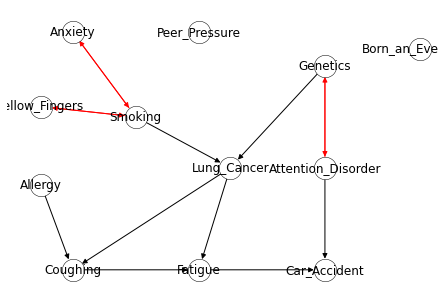

--------Step: 12--------
Total_score:  2573.0381883674795
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]]


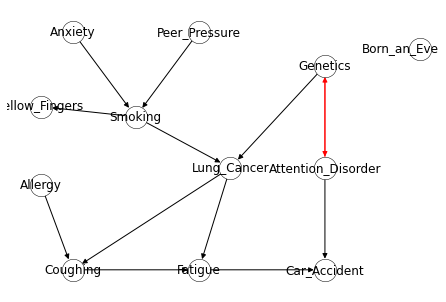

In [19]:
import matplotlib.pyplot as plt
i = 1
print("Total_score: ", 0)
for key, adj in enumerate(inter_adjs):
    fig = plt.figure(i)   
    print("--------Step: {}--------".format(i))
    print("Total_score: ", inter_scores[key])
    _ = draw_from_adj(adj)
    display(fig)
    i += 1
    plt.close()

Here we use GES package for a clearer demonstration. This package contains only a gaussian score calculating method. We canb use GES algorithm for exclusively categorical data, or Bayesion Network learn (BNlearn) when your data is mixed (continuous and categorical variables).

The GES implementation in DoWhy is wrapper for the GES package, which you can call as follows. Note that we need a DAG for DoWhy to do further estimation.

[[0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]]


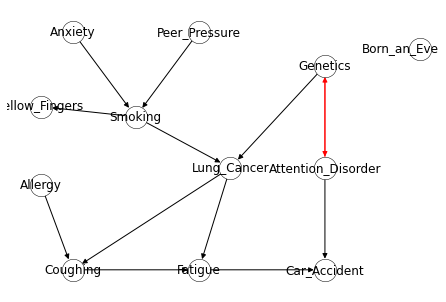

In [20]:
from dowhy.graph_learners.ges import GES

learner = GES(train, 'ges')
_ = learner.learn_graph()
adj = learner._adjacency_matrix
G = draw_from_adj(adj)